### ECON323 Final Project

This project will be in two parts:

#### 1) Data Cleaning and LASSO Regression
First, I will clean heart failure clinical records data provided by Davide Chicco and Giuseppe Jurman.

I will then run a group LASSO regression on the data to assess the effect of anaemia, creatinine phosphokinase, diabetes, ejection fractions, high blood pressure, platelet count, serum creatinine, serum sodium, gender, smoking status, and whether death occurred following heart failure.

#### 2) Data Scraping and Data Visualization

Then, I will scrape Twitter data to examine the social awareness of heart disease and heart failure in the media. I will compare the awareness of heart disease and heart failure to the number of heart disease-related deaths that occur by month, in the year 2018, in Canada.

The purpose of this project was to focus on heart and stroke data in Canada.

In [308]:
# pip install git+https://github.com/JustAnotherArchivist/snscrape.git

# Using snscrape to scrape Twitter data

import snscrape.modules.twitter as sntwitter

In [309]:
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import numpy as np
import pandas as pd

from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, ensemble, preprocessing
)
import itertools

data = pd.read_csv(r"/home/jupyter/Heart Failure Data.csv")
# Filtering heart failures that led to death and removing 'time' following heart failure
passed = data[data['DEATH_EVENT'] == 1].drop(['time', 'DEATH_EVENT'], axis = 1)

deaths = pd.read_csv(r"/home/jupyter/Deaths, monthly, Canada, 2018.csv")

### Section 1: Datasets

There are multiple datasets used in this project: (1) heart failure clinical records provided by Davide Chicco; (2) heart and stroke data scraped from Twitter; and (3) monthly fatalities data provided by Stats Canada.

1. I limit my data set to heart failure events that resulted in death. The heart failure records specifically focus on the effect of anaemia, creatinine phosphokinase (ATP in the heart), diabetes, ejection fractions (how well your heart pumps blood), high blood pressure, platelet count, sodium levels, gender, and smoking on the age of a heart attack.
2. I used the key word 'heart attack' to gather data from Twitter.

In [310]:
passed.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0


In [311]:
# Creating the train and test data points

train = passed.sample(frac = 0.9, random_state=100)
test = passed.drop(train.index)

y = passed.iloc[:, 0]
X = passed.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
y_train = train.iloc[:, 0]
X_train = train.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
y_test = test.iloc[:, 0]
X_test = test.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]

### Section 2: LASSO Regression

I begin by fitting my heart failure data to a LASSO model.

In [312]:
# Fitting a LASSO model to the training data, using cross-validation to determine the regularization parameter.

lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
alpha_1 = -np.log10(lasso.alpha_)

def mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

def fit_coef(mod, X_train, X_test, y_train, y_test):
    x = mod.fit(X_train, y_train)
    return x


In [313]:
y = fit_coef(linear_model.Lasso(alpha = alpha_1, max_iter = 100_000),
         X_train, X_test, y_train, y_test)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19812.86398284328, tolerance: 1.491057557633721
  model = cd_fast.enet_coordinate_descent(


In [314]:
coeffs = y.coef_
coeffs

array([-1.97310939e+01, -3.13595829e-03,  3.00999273e+01,  1.55774502e-01,
        3.30801508e+01, -3.99565295e-05,  2.76103348e+00,  6.69853138e-01,
        5.99219615e+01, -5.08216837e+01])

In [315]:
mses(linear_model.Lasso(alpha = alpha_1, max_iter = 20_000),
         X_train, X_test, y_train, y_test)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19812.86398284328, tolerance: 1.491057557633721
  model = cd_fast.enet_coordinate_descent(


{'mse_train': 1000.9442359271069, 'mse_test': 3562.1358129329224}

In [316]:
a = passed.iloc[:, 1] * coeffs[0] + passed.iloc[:, 2] * coeffs[1] + passed.iloc[:, 3] * coeffs[2] + passed.iloc[:, 4] * coeffs[3]

In [317]:
b = passed.iloc[:, 5] * coeffs[4] + passed.iloc[:, 6] * coeffs[5] + passed.iloc[:, 7] * coeffs[6] + passed.iloc[:, 8] * coeffs[7]

In [318]:
c = passed.iloc[:, 9] * coeffs[8] + passed.iloc[:, 10] * coeffs[9]

In [319]:
def lasso_reg():
    """ This function will average the results over multiple training samples """
    
    # Taking a random sample of the training data
    train = passed.sample(frac = 0.9, random_state=100)
    test = passed.drop(train.index)

    y_train = train.iloc[:, 0]
    X_train = train.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
    y_test = test.iloc[:, 0]
    X_test = test.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
    
    lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
    alpha_1 = -np.log10(lasso.alpha_)
    
    z = fit_coef(linear_model.Lasso(alpha = alpha_1, max_iter = 2_000),
         X_train, X_test, y_train, y_test)
    
    a = passed.iloc[:, 1] * coeffs[0] + passed.iloc[:, 2] * coeffs[1] + passed.iloc[:, 3] * coeffs[2] + passed.iloc[:, 4] * coeffs[3]
    b = passed.iloc[:, 5] * coeffs[4] + passed.iloc[:, 6] * coeffs[5] + passed.iloc[:, 7] * coeffs[6] + passed.iloc[:, 8] * coeffs[7]
    c = passed.iloc[:, 9] * coeffs[8] + passed.iloc[:, 10] * coeffs[9]
    
    return a + b + c

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19812.86398284328, tolerance: 1.491057557633721
  model = cd_fast.enet_coordinate_descent(


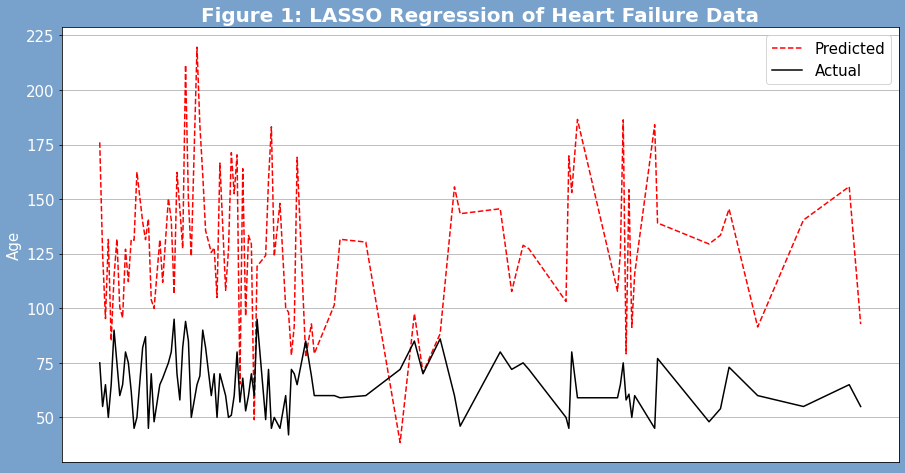

In [320]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

plt.yticks(fontsize=15, color='white')
plt.xticks([])
plt.ylabel('Age', fontsize=15, color='white')

plt.title('Figure 1: LASSO Regression of Heart Failure Data', fontsize=20, fontweight='bold', color='white')

plt.plot(lasso_reg(), 'r--', label='Predicted')
plt.plot(passed['age'], 'black', label='Actual')
plt.legend(fontsize=15)
plt.grid()


fig.savefig("lasso.png", dpi=100, edgecolor=fig.get_edgecolor())

As can be seen in Figure 1, the LASSO regression used does not provide an accurate estimate of the various determinants of a heart attack. I move to a neural network approach.

### Section 3: Neural Network

Using cross-validation to determine the best estimators was not possible in Jupyter. I have inserted a sample of my code.

```python
nn_param = {'hidden_layer_sizes': list(itertools.combinations_with_replacement([5, 10, 15],2))
            + list(itertools.combinations_with_replacement([5, 10, 15],3))
            + list(itertools.combinations_with_replacement([5, 10, 15],4))
            + list(itertools.combinations_with_replacement([5, 10, 15],5))}

nn_grid = model_selection.GridSearchCV(neural_network.MLPRegressor(solver='adam', max_iter = 10_000, learning_rate_init=0.001),
                                               nn_param, scoring = 'neg_mean_squared_error')
nn_grid.fit(X_train, y_train)

print(nn_grid.best_estimator_)
```

This code indicates that the best estimators are: MLPRegressor(hidden_layer_sizes=(5, 5, 5, 5, 5, 5), max_iter=10_000)

In [321]:
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor((5, 5, 5, 5, 5), solver='adam', max_iter=20_000,
                               learning_rate_init=0.001))

nn_scaled_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(5, 5, 5, 5, 5),
                              max_iter=20000))])

In [322]:
data = nn_scaled_model.predict(X)
data

array([ 61.08941977,  55.76409642,  57.72553555,  54.13984731,
        63.97406987,  87.80171701,  61.85042887,  60.43171457,
       124.11118625,  79.0105681 ,  84.96916561,  67.50679418,
        50.04390433,  57.48345932,  78.85484404,  90.03964138,
        51.62881134,  76.39182993,  47.42185694,  60.38157734,
        67.22085097,  73.25642193,  80.05770923,  82.3152389 ,
        98.4494723 ,  56.2637308 ,  84.15245004,  93.36541085,
        83.92019836,  50.04542093,  64.50177946,  68.30637761,
        91.81552442,  83.67939188,  59.92317821,  65.40647684,
        50.14512522,  70.50512897,  60.09253994,  58.80380192,
        54.05940531,  56.12011337,  84.9588948 ,  56.79991945,
        72.52647975,  54.80743996,  60.10916417,  69.14697109,
        33.7180444 ,  95.7063285 ,  56.22864027,  73.80022271,
        74.1629565 ,  70.51164836,  45.20178618,  64.48557506,
        42.62779497,  74.75892122,  67.84792031,  65.33216324,
        84.21534727,  61.74889675,  59.84616765,  54.42

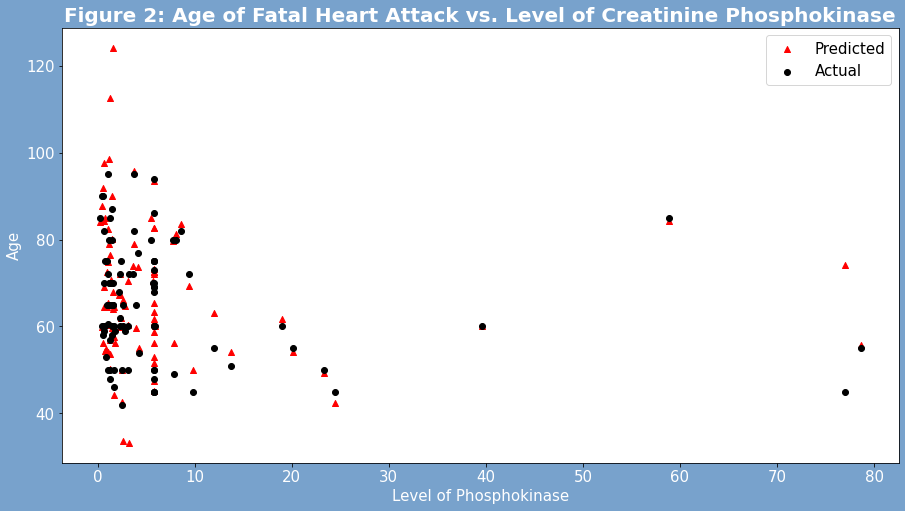

In [323]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

x_scatter = passed['creatinine_phosphokinase']
plt.scatter(x_scatter / 100, data, color='red', marker='^', label='Predicted')
y = passed.iloc[:, 0]
plt.scatter(x_scatter / 100, y, color='black', label='Actual')
plt.title('Figure 2: Age of Fatal Heart Attack vs. Level of Creatinine Phosphokinase', fontsize=20, fontweight='bold', color='white')


plt.xticks(fontsize=15, color='white')
plt.xlabel('Level of Phosphokinase', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.ylabel('Age', fontsize=15, color='white')
plt.legend(fontsize=15)

fig.savefig("scatter phosphokinase.png", dpi=100, edgecolor=fig.get_edgecolor())

In [324]:
data

array([ 61.08941977,  55.76409642,  57.72553555,  54.13984731,
        63.97406987,  87.80171701,  61.85042887,  60.43171457,
       124.11118625,  79.0105681 ,  84.96916561,  67.50679418,
        50.04390433,  57.48345932,  78.85484404,  90.03964138,
        51.62881134,  76.39182993,  47.42185694,  60.38157734,
        67.22085097,  73.25642193,  80.05770923,  82.3152389 ,
        98.4494723 ,  56.2637308 ,  84.15245004,  93.36541085,
        83.92019836,  50.04542093,  64.50177946,  68.30637761,
        91.81552442,  83.67939188,  59.92317821,  65.40647684,
        50.14512522,  70.50512897,  60.09253994,  58.80380192,
        54.05940531,  56.12011337,  84.9588948 ,  56.79991945,
        72.52647975,  54.80743996,  60.10916417,  69.14697109,
        33.7180444 ,  95.7063285 ,  56.22864027,  73.80022271,
        74.1629565 ,  70.51164836,  45.20178618,  64.48557506,
        42.62779497,  74.75892122,  67.84792031,  65.33216324,
        84.21534727,  61.74889675,  59.84616765,  54.42

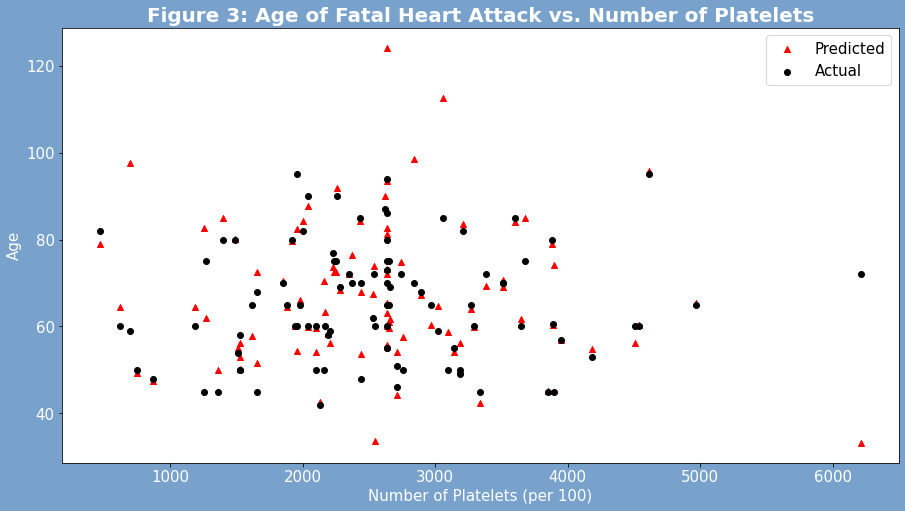

In [325]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

x_scatter = passed['platelets']
plt.scatter(x_scatter / 100, data, color='red', marker='^', label='Predicted')
y = passed.iloc[:, 0]
plt.scatter(x_scatter / 100, y, color='black', label='Actual')
plt.title('Figure 3: Age of Fatal Heart Attack vs. Number of Platelets', fontsize=20, fontweight='bold', color='white')


plt.xticks(fontsize=15, color='white')
plt.xlabel('Number of Platelets (per 100)', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.ylabel('Age', fontsize=15, color='white')
plt.legend(fontsize=15)

fig.savefig("scatter platelets.png", dpi=100, edgecolor=fig.get_edgecolor())

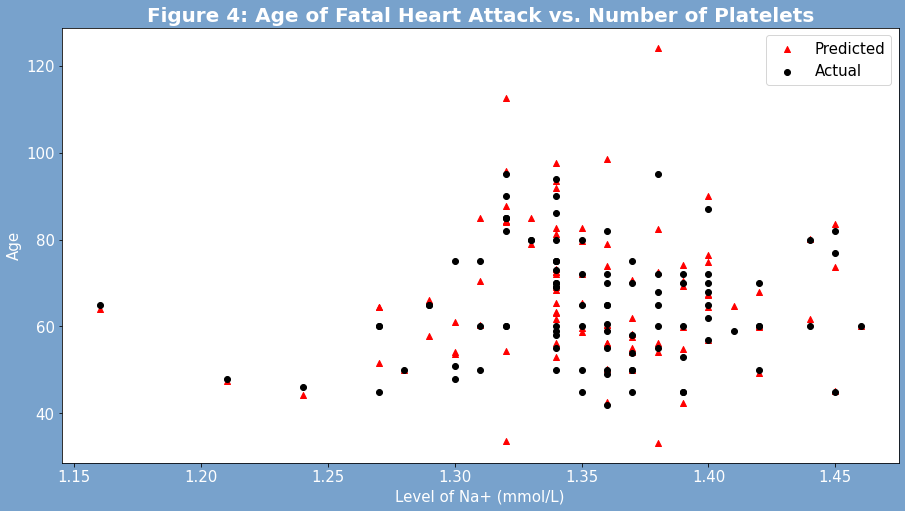

In [326]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

x_scatter = passed['serum_sodium']
plt.scatter(x_scatter / 100, data, color='red', marker='^', label='Predicted')
y = passed.iloc[:, 0]
plt.scatter(x_scatter / 100, y, color='black', label='Actual')
plt.title('Figure 4: Age of Fatal Heart Attack vs. Number of Platelets', fontsize=20, fontweight='bold', color='white')


plt.xticks(fontsize=15, color='white')
plt.xlabel('Level of Na+ (mmol/L)', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.ylabel('Age', fontsize=15, color='white')
plt.legend(fontsize=15)

fig.savefig("scatter na.png", dpi=100, edgecolor=fig.get_edgecolor())

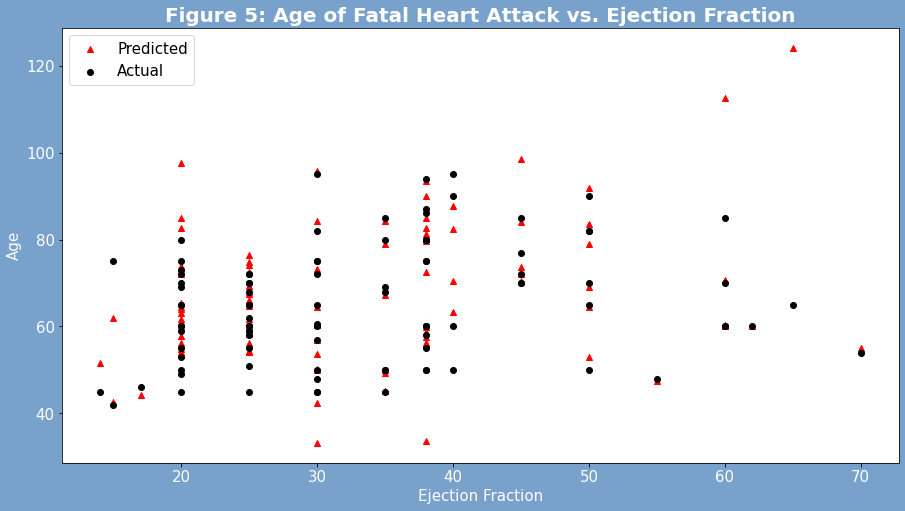

In [327]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

x_scatter = passed['ejection_fraction']
plt.scatter(x_scatter, data, color='red', marker='^', label='Predicted')
y = passed.iloc[:, 0]
plt.scatter(x_scatter, y, color='black', label='Actual')
plt.title('Figure 5: Age of Fatal Heart Attack vs. Ejection Fraction', fontsize=20, fontweight='bold', color='white')


plt.xticks(fontsize=15, color='white')
plt.xlabel('Ejection Fraction', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.ylabel('Age', fontsize=15, color='white')
plt.legend(fontsize=15)

fig.savefig("scatter ef.png", dpi=100, edgecolor=fig.get_edgecolor())

As can be observed, the use of a neural network results in visible similarities between the predicted and actual data. From these plots, we can draw certain conclusions. For example:

1) There was no obvious relationship between platelet count and heart failure.
2) Individuals with Na+ levels in their blood had a higher chance of heart failure, regardless of age.

### Section 4: Scraping Twitter Data

In [328]:
def tweetie(keyword, since, until):
    tweets = []
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f"{keyword} since:{since} until:{until}").get_items()):
        if i > 1_000:
            break
        tweets.append([tweet.date, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount])
    
    df_twt = pd.DataFrame(tweets, columns = ['Date', 'Replies', 'Retweets', 'Likes', 'Quotes'])
    return df_twt

In [329]:
begin = ['2018-01-01', '2018-02-01', '2018-03-01',
         '2018-04-01', '2018-05-01', '2018-06-01',
         '2018-07-01', '2018-08-01', '2018-09-01']

end = ['2018-01-31', '2018-02-28', '2018-03-31',
       '2018-04-30', '2018-05-31', '2018-06-30',
       '2018-07-31', '2018-08-31', '2018-09-30']

monthly_replies = []
monthly_retweets = []
monthly_likes = []
monthly_quotes = []

for i in range(len(begin)):
    x = tweetie('heart attack', begin[i], end[i])
    monthly_replies.append(np.sum(x['Replies']))
    monthly_retweets.append(np.sum(x['Retweets']))
    monthly_likes.append(np.sum(x['Likes']))
    monthly_quotes.append(np.sum(x['Quotes']))

In [330]:
# Total monthly deaths (from Stats Canada)
dth = [28_815, 24_065, 25_275, 23_550, 22_975, 21_650, 21_940, 21_865, 21_840]
# Total monthly deaths, due to heart disease (from Stats Canada)
doh = np.array([5560, 4640, 4785, 4525, 4410, 4125, 3975, 3975, 3945])

# Monthly Twitter data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
monthly_replies = np.array(monthly_replies)
monthly_retweets = np.array(monthly_retweets)
monthly_likes = np.array(monthly_likes)
monthly_quotes = np.array(monthly_quotes)
monthly_replies

array([ 310,  807, 1188,  368,  323,  287,  406,  358,  399])

### Section 5: Plotting Twitter Data

February is considered 'Heart Health' month. As can be seen, there is an increase in relevance of tweets that contain reference to 'heart attacks' in that time period. What is potentially interesting is that we can see a small decrease in the number of deaths due to heart failure in the months that followed February/March, which suggests social awareness of heart failure may lead to decreased deaths due to heart failure.

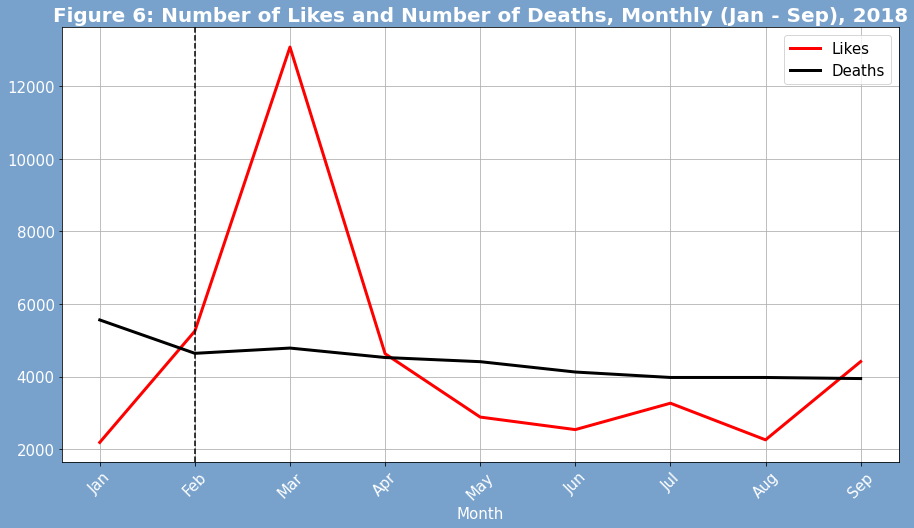

In [331]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

plt.title('Figure 6: Number of Likes and Number of Deaths, Monthly (Jan - Sep), 2018', color='white', fontsize=20, fontweight='bold')
plt.plot(months, monthly_likes, 'r', linewidth = 3, label='Likes')
plt.plot(months, doh, 'black', linewidth = 3, label='Deaths')
plt.xticks(fontsize=15, rotation=45, color='white')
plt.xlabel('Month', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.legend(fontsize=15)
plt.axvline(x='Feb', color='black', ls='dashed')
plt.grid()

fig.savefig("likes.png", dpi=100, edgecolor=fig.get_edgecolor())

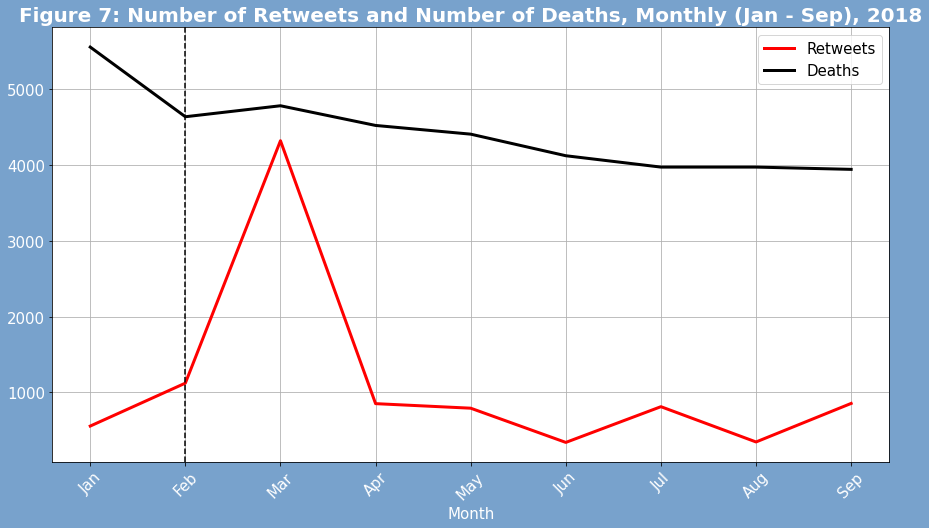

In [332]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

plt.title('Figure 7: Number of Retweets and Number of Deaths, Monthly (Jan - Sep), 2018', color='white', fontsize=20, fontweight='bold')
plt.plot(months, monthly_retweets, 'r', linewidth = 3, label='Retweets')
plt.plot(months, doh, 'black', linewidth = 3, label='Deaths')
plt.xticks(fontsize=15, rotation=45, color='white')
plt.xlabel('Month', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.legend(fontsize=15)
plt.axvline(x='Feb', color='black', ls='dashed')
plt.grid()

fig.savefig("retweets.png", dpi=100, edgecolor=fig.get_edgecolor())

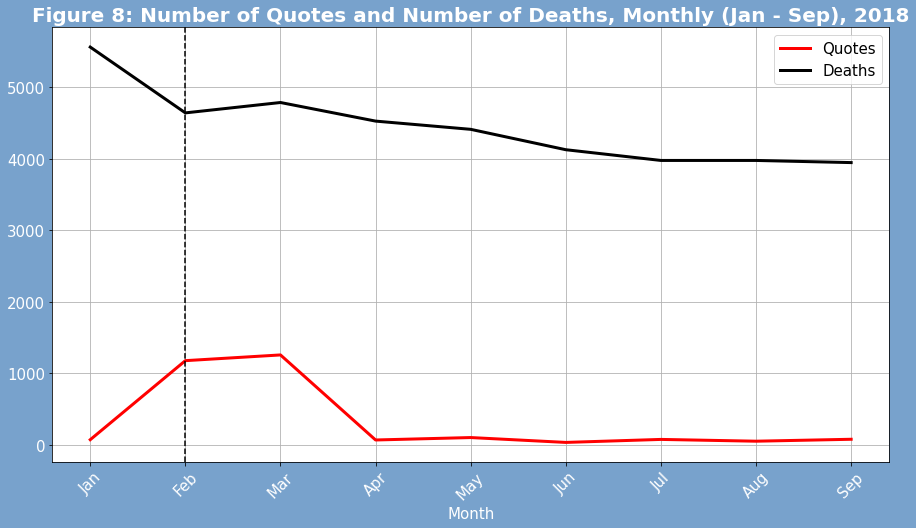

In [333]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

plt.title('Figure 8: Number of Quotes and Number of Deaths, Monthly (Jan - Sep), 2018', color='white', fontsize=20, fontweight='bold')
plt.plot(months, monthly_quotes, 'r', linewidth = 3, label='Quotes')
plt.plot(months, doh, 'black', linewidth = 3, label='Deaths')
plt.xticks(fontsize=15, rotation=45, color='white')
plt.xlabel('Month', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.legend(fontsize=15)
plt.axvline(x='Feb', color='black', ls='dashed')
plt.grid()

fig.savefig("quotes.png", dpi=100, edgecolor=fig.get_edgecolor())

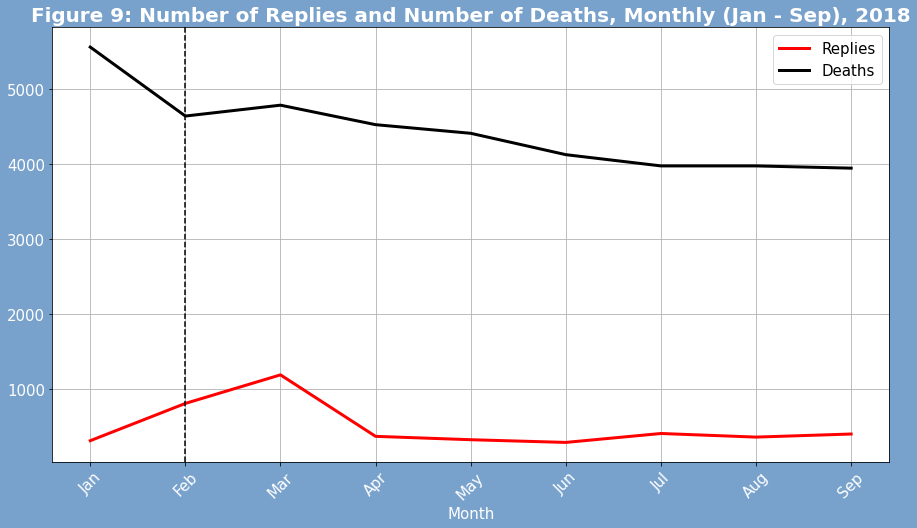

In [334]:
fig = plt.figure(facecolor="#78A2CC", figsize=(15, 8), linewidth = 100, edgecolor="#78A2CC")
ax.set_facecolor(color="#FBFAF5")

plt.title('Figure 9: Number of Replies and Number of Deaths, Monthly (Jan - Sep), 2018', color='white', fontsize=20, fontweight='bold')
plt.plot(months, monthly_replies, 'r', linewidth = 3, label='Replies')
plt.plot(months, doh, 'black', linewidth = 3, label='Deaths')
plt.xticks(fontsize=15, rotation=45, color='white')
plt.xlabel('Month', fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
plt.legend(fontsize=15)
plt.axvline(x='Feb', color='black', ls='dashed')
plt.grid()

fig.savefig("replies.png", dpi=100, edgecolor=fig.get_edgecolor())